In [1]:
!pip install gymnasium
# !pip install torchviz
!pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 73.0 MB/s eta 0:00:00


In [2]:
# %matplotlib inline
# %load_ext tensorboard
# %tensorboard --logdir logs

In [3]:
from itertools import count
import random
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import math
from collections import deque, namedtuple
import random
from torchvision.models import resnet18
import numpy as np

2024-03-26 19:09:53.661580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 19:09:53.661674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 19:09:53.796003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def render_environment(env):
    plt.figure(figsize=(6, 4))
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

In [5]:
env = gym.make("CartPole-v1",render_mode="rgb_array")
writer = SummaryWriter("logs")
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [6]:
#HYPER-PARAMETERS
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 512
GAMMA = 0.4
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
REPLAY_BUFFER_SIZE = 10000

In [7]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
resnet_model = resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [9]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(resnet_model.children())[:-1])
        for param in self.features.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.features(x)
        return x

In [10]:
class DQN(nn.Module):
    def __init__(self, n_observations,n_actions):
        super(DQN, self).__init__()
        self.cnn = ResNetFeatureExtractor()
        self.layer1 = nn.Linear(512, 128)
        self.layer2 = nn.Linear(128, 56)
        self.layer3 = nn.Linear(56, n_actions)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

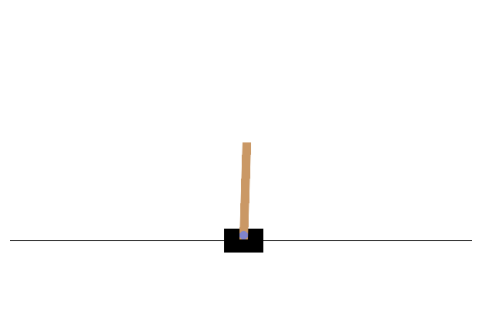

In [11]:
n_actions = env.action_space.n
state, info = env.reset(seed=42)
n_observations = len(state)
render_environment(env)

In [12]:
preprocess = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(448), 
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

In [13]:
def select_action(state,policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )

In [14]:
steps_done = 0

In [15]:
def single_run(BATCH_SIZE, GAMMA, EPS_START, EPS_END, EPS_DECAY, TAU, LR,REPLAY_BUFFER_SIZE,EXP_NAME):
  writer = SummaryWriter(f'logs/{EXP_NAME}/CNN_BASED/RESNET/BATCH_SIZE-{BATCH_SIZE}-GAMMA-{GAMMA}-EPS_START-{EPS_START}-EPS_END-{EPS_END}-EPS_DECAY-{EPS_DECAY}-TAU-{TAU}-LR-{LR}-REPLAY_BUFFEER_SIZE-{REPLAY_BUFFER_SIZE}')
  policy_net = DQN(n_observations, n_actions).to(device)
  target_net = DQN(n_observations, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())
  memory = ReplayBuffer(REPLAY_BUFFER_SIZE)
  optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
  steps_done = 0
  episode_durations = []
  episode_rewards = []
  epoch_q_values = []
  if torch.cuda.is_available() or torch.backends.mps.is_available():
      num_episodes = 500
  else:
      num_episodes = 50

  for i_episode in tqdm(range(num_episodes)):
      # Initialize the environment and get its state
      state, info = env.reset()
      image = env.render()
      image = preprocess(image)
      # print(image.shape)
      state = torch.tensor(image, dtype=torch.float32, device=device).unsqueeze(0)
      # print(state.shape)
      episode_reward = 0
      epoch_q_value = 0
      for t in count():
          action = select_action(state,policy_net)
          observation, reward, terminated, truncated, _ = env.step(action.item())
          reward = torch.tensor([reward], device=device)
          episode_reward+=reward.item()

          q_values = policy_net(state)
          q_value = q_values[0, action].item()
          epoch_q_value += q_value


          done = terminated or truncated

          if terminated:
              next_state = None
          else:
              image = env.render()
              image = preprocess(image)
              next_state = torch.tensor(image, dtype=torch.float32, device=device).unsqueeze(0)

          memory.push(state, action, next_state, reward)
          state = next_state

          # Perform one step of the optimization (on the policy network)
          if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)),
                device=device,
                dtype=torch.bool,
            )
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)
            state_action_values = policy_net(state_batch).gather(1, action_batch)
            next_state_values = torch.zeros(BATCH_SIZE, device=device)
            with torch.no_grad():
                next_state_values[non_final_mask] = (
                    target_net(non_final_next_states).max(1).values
                )
            expected_state_action_values = (next_state_values * GAMMA) + reward_batch
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            writer.add_scalar("Loss", loss.item(), i_episode)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()

          target_net_state_dict = target_net.state_dict()
          policy_net_state_dict = policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
          target_net.load_state_dict(target_net_state_dict)
          if done:
              writer.add_scalar("Average Reward",episode_reward,i_episode)
              average_q_value = epoch_q_value / (t + 1)
              epoch_q_values.append(average_q_value)
              writer.add_scalar("Average Q-value", average_q_value, i_episode)
              episode_durations.append(t + 1)
              break
  writer.add_hparams({'LR': LR, 'BATCH_SIZE': BATCH_SIZE, 'GAMMA':GAMMA,'EPS_START':EPS_START,'EPS_END':EPS_END,'TAU':TAU,'REPLAY_BUFFER_SIZE':REPLAY_BUFFER_SIZE}, {'hparam/loss': loss.item(), 'hparam/reward': reward,'average_q_value':average_q_value})
  torch.save(policy_net.state_dict(), 'dqn_cnn_model.pth')

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
REPLAY_BUFFER_SIZE = 100000
BATCH_SIZE = 512
GAMMA = 0.4
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
single_run(BATCH_SIZE, GAMMA, EPS_START, EPS_END, EPS_DECAY, TAU, LR,REPLAY_BUFFER_SIZE,'REPLAY_BUFFER')

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_26/362562523.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(image, dtype=torch.float32, device=device).unsqueeze(0)
/tmp/ipykernel_26/362562523.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(image, dtype=torch.float32, device=device).unsqueeze(0)


In [18]:
# from tensorboard import notebook
# notebook.list()
# notebook.display(port=6006, height=500)

In [19]:
# policy_net = DQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load('dqn_cnn_model.pth'))
# policy_net.eval() 

In [20]:
# !pip install imageio
# import imageio
# from IPython.display import Video

In [21]:
# state,_ = env.reset()
# image = env.render()
# image = preprocess(image)
# state = torch.tensor(image, dtype=torch.float32, device=device).unsqueeze(0)

# done = False
# frames = []
# while not done:
#   frames.append(env.render())
#   with torch.no_grad():
#         image = env.render()
#         image = preprocess(image)
#         state = torch.tensor(image, dtype=torch.float32, device=device).unsqueeze(0)
#         action = policy_net(state).argmax(dim=1).item()
#   state, reward, terminated, truncated,_ = env.step(action)
#   done = terminated or truncated
# imageio.mimsave('output.mp4', frames)
# env.close()

# Video("output.mp4", embed=True)